# SQL and BigQuery Practice Notebook

The purpose of this notebook is to keep myself sharp when it comes to accessing APIs and examining BigQuery datasets.

# Connecting to the API

In [1]:
from google.cloud import bigquery

To begin, we'll need a Google Cloud developer account. I already have one, but in case you need one, you can start one <a href="https://console.cloud.google.com/">here</a>. You'll also need to download <a href="https://cloud.google.com/sdk">Cloud SDK</a>. Once you have access to your Google Cloud developer account, begin a new project, click on the hamburger menu in the upper left corner > IAM & Admin > Service Accounts, then create a service account. Name your project > Create > Continue. Click the name of the service account, and scroll down to Add Key, and create a new key. Choose the JSON option and download the key file into your local project folder. 

You'll need to provide your credentials from the key file to access the BigQuery database. You can set the credentials on the command line (<a href="https://cloud.google.com/docs/authentication/getting-started#auth-cloud-implicit-python">instructions</a>) but I kept getting errors, so another option is to set it as I did in the cell below.

In [2]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "Practice-Project-7d7e549fec37.json"

print('Credentials from environ: {}'.format(
    os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')))

Credentials from environ: Practice-Project-7d7e549fec37.json


In [3]:
# Creating a client object
client = bigquery.Client()

This project will use a public dataset of Chicago Crime. We need to refer to the dataset and fetch it with an API request.

In [4]:
# Reference to the dataset
dataset_ref = client.dataset("chicago_crime", project="bigquery-public-data")

# API request
dataset = client.get_dataset(dataset_ref)

Let's check out the tables:

In [5]:
tables = list(client.list_tables(dataset))
print("Num. of tables:", len(tables))
for table in tables:
    print(table.table_id)

Num. of tables: 1
crime


We also need to fetch the tables from the dataset:

In [6]:
# Referecing the 'crime' table from the list above
table_ref = dataset_ref.table("crime")

# API request
table = client.get_table(table_ref)

Let's check out the schema of the table:

In [7]:
table.schema

[SchemaField('unique_key', 'INTEGER', 'REQUIRED', 'Unique identifier for the record.', (), None),
 SchemaField('case_number', 'STRING', 'NULLABLE', 'The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.', (), None),
 SchemaField('date', 'TIMESTAMP', 'NULLABLE', 'Date when the incident occurred. this is sometimes a best estimate.', (), None),
 SchemaField('block', 'STRING', 'NULLABLE', 'The partially redacted address where the incident occurred, placing it on the same block as the actual address.', (), None),
 SchemaField('iucr', 'STRING', 'NULLABLE', 'The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.', (), None),
 SchemaField('primary_type', 'STRING', 'NULLABLE', 'The primary description of the IUCR code.', (), None),
 SchemaField('description', 'STRING', 'NULLABLE', 'The secondary description of the IUCR code, a s

The schema includes the name of the field, the datatype, mode which signifies whether the column allows null values, and a short description of the contents. 

We can look at the first few rows of the table in a dataframe.

In [69]:
chicago_crime_df = client.list_rows(table, max_results=5).to_dataframe()
chicago_crime_df.head()

/Users/Allie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the tabledata.list endpoint.
  """Entry point for launching an IPython kernel.
/Users/Allie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PyarrowMissingWarning: Converting to a dataframe without pyarrow installed is often slower and will become unsupported in the future. Please install the pyarrow package.
  """Entry point for launching an IPython kernel.


,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,2147136,HH383717,2002-05-20 08:00:00+00:00,031XX S ASHLAND AVE,1563,SEX OFFENSE,CRIMINAL SEXUAL ABUSE,CTA BUS,True,False,...,11,59,17,None,None,2002,2015-08-17 15:03:40+00:00,None,None,None
1,10536569,HZ280501,2014-01-10 14:00:00+00:00,050XX S ARCHER AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER,False,False,...,14,57,11,None,None,2014,2016-05-27 15:48:00+00:00,None,None,None
2,10779500,HZ546034,2008-04-01 12:00:00+00:00,064XX S LONG AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER,False,False,...,13,64,11,None,None,2008,2016-12-10 15:49:45+00:00,None,None,None
3,10481920,HZ221713,2015-08-20 12:00:00+00:00,025XX E 93RD ST,0485,BATTERY,AGGRAVATED OF A CHILD,RESIDENCE,False,True,...,7,48,04B,None,None,2015,2016-04-12 15:48:52+00:00,None,None,None
4,10427182,HZ164759,2015-11-12 17:00:00+00:00,030XX N NORDICA AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,36,18,11,None,None,2015,2018-02-09 15:44:29+00:00,None,None,None


# Running Queries

We'll begin by selecting only crimes which happened at a residential location. But first, we have to keep in mind that many datasets are massive and there can be limits set by your organization. We can first do a "dry run" of the query to see how much data is processed. 

In [10]:
query = """
        SELECT primary_type
        FROM bigquery-public-data.chicago_crime.crime
        WHERE location_description = 'RESIDENCE'
        """

#Configuring dry run rules for query
dry_run_config = bigquery.QueryJobConfig(dry_run=True)

dry_run_query_job = client.query(query, job_config=dry_run_config)

print(f"This query will process {dry_run_query_job.total_bytes_processed} bytes.")

This query will process 180666702 bytes.


The next cell will then set a limit to keep our query in the safe zone by calling for a one gigabyte limit. 

In [11]:
# Configuring byte limit
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)

query_job = client.query(query, job_config=safe_config)

# Putting results into a dataframe
results = query_job.to_dataframe()

print(results.head())

                 primary_type
0          DECEPTIVE PRACTICE
1  OFFENSE INVOLVING CHILDREN
2               OTHER OFFENSE
3          DECEPTIVE PRACTICE
4           CRIMINAL TRESPASS


In [12]:
len(results)

1218620

Now let's count how many of each type of crime occurred at residential properties and show from highest count to lowest. Notice the alias for the 'count' column.

In [13]:
query2 = """
        SELECT primary_type, COUNT(primary_type) AS count
        FROM bigquery-public-data.chicago_crime.crime
        WHERE location_description = 'RESIDENCE'
        GROUP BY primary_type
        ORDER BY count desc
        """
# Using the safe configuration again
query2_job = client.query(query2, job_config=safe_config)

results2 = query2_job.to_dataframe()

print(results2.head())

      primary_type   count
0          BATTERY  276014
1    OTHER OFFENSE  203029
2            THEFT  157557
3  CRIMINAL DAMAGE  154968
4         BURGLARY  137775


Let's see which types of crimes occured less than 1000 times with the HAVING clause.

In [14]:
query3 = """
        SELECT primary_type, COUNT(primary_type) AS count
        FROM bigquery-public-data.chicago_crime.crime
        WHERE location_description = 'RESIDENCE'
        GROUP BY primary_type
        HAVING count < 1000
        ORDER BY count desc
        """
# Using the safe configuration again
query3_job = client.query(query3, job_config=safe_config)

results3 = query3_job.to_dataframe()

print(results3.head())

                       primary_type  count
0                      PROSTITUTION    595
1           CRIMINAL SEXUAL ASSAULT    539
2  INTERFERENCE WITH PUBLIC OFFICER    486
3                         OBSCENITY    309
4              LIQUOR LAW VIOLATION    276


We can also combine two functions, WITH and AS to form a common table expression, so we can refer back to the query and query them further. Keep in mind that they only exist in the query and cannot be referenced outside. Example: 

In [15]:
query4 = """
        WITH uncommon_crimes AS
        (
        SELECT primary_type, COUNT(primary_type) AS count
        FROM bigquery-public-data.chicago_crime.crime
        WHERE location_description = 'RESIDENCE'
        GROUP BY primary_type
        HAVING count < 1000
        ORDER BY count desc
        )
        SELECT primary_type 
        FROM uncommon_crimes
        """
query4_job = client.query(query4, job_config=safe_config)

results4 = query4_job.to_dataframe()

print(results4.head())

                       primary_type
0                      PROSTITUTION
1           CRIMINAL SEXUAL ASSAULT
2  INTERFERENCE WITH PUBLIC OFFICER
3                         OBSCENITY
4              LIQUOR LAW VIOLATION


We can also quickly plot the query by using matplotlib.

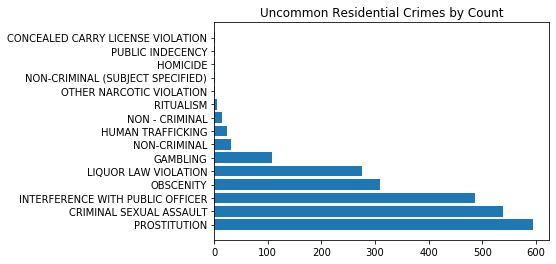

In [141]:
import matplotlib.pyplot as plt
plt.barh(results3['primary_type'], results3['count'])
plt.yticks( rotation='horizontal')
plt.title("Uncommon Residential Crimes by Count");

In order to improve my data visualization skills in Tableau, I'm going to select all crimes during 2019 and download into an Excel spreadsheet. 

In [74]:
# Dates are inclusive in SQL
query5 = """SELECT * 
            FROM bigquery-public-data.chicago_crime.crime c
            WHERE c.date BETWEEN '2019-01-01' AND '2019-12-31';"""

query5_job = client.query(query5, job_config=safe_config)

chicago_crime_df = query5_job.to_dataframe()

The datetime objects in the columns 'date' and 'updated_on' contain timezones which aren't allowed in Excel spreadsheets, so we'll remove those. 

In [75]:
chicago_crime_df['date'] = chicago_crime_df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
chicago_crime_df['updated_on'] = chicago_crime_df['updated_on'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

In [76]:
len(chicago_crime_df)

259525

Over 250,000 crimes were reported in 2019, not including murder as those crimes are kept separate.

In [78]:
chicago_crime_df.head()

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,11636912,JC202107,2019-03-26 15:26:00,007XX E 111TH ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,POLICE FACILITY/VEH PARKING LOT,True,True,...,9.0,50,26,1183356.0,1831503.0,2019,2019-06-30 15:56:27,41.692834,-87.604319,"(41.692833841, -87.60431945)"
1,11719073,JC301927,2019-04-24 22:30:00,064XX S NARRAGANSETT AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,23.0,64,02,1134872.0,1860926.0,2019,2019-06-30 15:56:27,41.774566,-87.781140,"(41.774565637, -87.781140173)"
2,11726456,JC311014,2019-06-18 01:30:00,049XX N NORDICA AVE,0554,ASSAULT,AGG PO HANDS NO/MIN INJURY,SIDEWALK,False,False,...,41.0,10,08A,1128606.0,1932315.0,2019,2019-06-30 15:56:27,41.970576,-87.802492,"(41.970575996, -87.802492422)"
3,11740399,JC327614,2019-06-29 14:00:00,069XX W DEVON AVE,0630,BURGLARY,ATTEMPT FORCIBLE ENTRY,RESIDENCE,False,False,...,41.0,10,05,1129202.0,1941950.0,2019,2019-07-06 16:09:10,41.997005,-87.800080,"(41.997005217, -87.800080263)"
4,11747821,JC336824,2019-07-06 01:20:00,096XX S AVENUE L,0498,BATTERY,AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET S...,RESIDENCE,True,True,...,10.0,52,04B,1201786.0,1841754.0,2019,2019-07-19 16:09:50,41.720516,-87.536498,"(41.720515598, -87.536497921)"


In [91]:
## Downloading for import into Tableau
# chicago_crime_df.to_excel('chicago_crime.xlsx')

Here's a sneak peak into the GeoJSON file that I'll use to create a dual axis map, featuring top 5 crimes per neighborhood. 

In [124]:
import geopandas
geojson_df = geopandas.read_file("Boundaries - Community Areas (current).geojson")

In [125]:
geojson_df.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [131]:
# Embedding Tableau Worksheet
%%HTML
<script type='text/javascript' src='https://prod-useast-a.online.tableau.com/javascripts/api/viz_v1.js'></script>
<div class='tableauPlaceholder' style='width: 1366px; height: 635px;'>
<object class='tableauViz' width='1366' height='635' style='display:none;'>
<param name='host_url' value='https%3A%2F%2Fprod-useast-a.online.tableau.com%2F' /> 
<param name='embed_code_version' value='3' /> 
<param name='site_root' value='&#47;t&#47;allisonkellystestsite' />
<param name='name' value='Book4&#47;Sheet2&#47;allisonkelly42@gmail.com&#47;42b5ea84-b60b-4e11-9020-36e6188e6128' />
<param name='tabs' value='no' />
<param name='toolbar' value='yes' />
<param name='showAppBanner' value='false' />
</object>
</div>

# Window Functions

Let's replicate the analytics shown above in Tableau with SQL by using window functions to combine non-aggregated and aggregated columns in one view.

In [133]:
top_5_crimes_by_neighborhood =  '''
                                SELECT * 
                                FROM (
                                SELECT c.community_area, c.primary_type, COUNT(c.primary_type) no_of_occurences,
                                RANK() OVER(PARTITION BY c.community_area ORDER BY COUNT(c.primary_type) DESC) as rank
                                FROM bigquery-public-data.chicago_crime.crime AS c
                                WHERE c.date BETWEEN '2019-01-01' AND '2019-12-31'
                                GROUP BY c.community_area, c.primary_type
                                    )
                                WHERE rank <=5
                                '''

In [134]:
top_5_crimes_by_neighborhood_job = client.query(top_5_crimes_by_neighborhood, job_config=safe_config)

top_5 = top_5_crimes_by_neighborhood_job.to_dataframe()

In [135]:
top_5.head(10)

,community_area,primary_type,no_of_occurences,rank
0,1,THEFT,1229,1
1,1,BATTERY,736,2
2,1,CRIMINAL DAMAGE,483,3
3,1,DECEPTIVE PRACTICE,285,4
4,1,ASSAULT,275,5
5,2,THEFT,921,1
6,2,BATTERY,588,2
7,2,CRIMINAL DAMAGE,404,3
8,2,DECEPTIVE PRACTICE,317,4
9,2,OTHER OFFENSE,240,5


In [140]:
len(top_5)

388

# Subqueries, CASE Clause, and Correlated Subqueries

As I've exhausted the resources at Kaggle, I'll move on to a Udemy course that I completed earlier this year and want to brush up on. I'll be applying the concepts I learned in the <a href="https://www.udemy.com/course/master-sql-for-data-science/"> Master SQL FOR Data Science</a> course on Google BigQuery's Stackoverflow dataset. 

In [142]:
# Reference to the dataset
stackoverflow_dataset_ref = client.dataset("stackoverflow", project="bigquery-public-data")

# API request
stackoverflow_dataset = client.get_dataset(stackoverflow_dataset_ref)

In [143]:
# Getting the list of tables
tables = list(client.list_tables(stackoverflow_dataset))
print("Num. of tables:", len(tables))
for table in tables:
    print(table.table_id)

Num. of tables: 16
badges
comments
post_history
post_links
posts_answers
posts_moderator_nomination
posts_orphaned_tag_wiki
posts_privilege_wiki
posts_questions
posts_tag_wiki
posts_tag_wiki_excerpt
posts_wiki_placeholder
stackoverflow_posts
tags
users
votes


Let's take a deeper dive into the schemas of a couple of the tables.

In [144]:
# Referencing the comments and post_history tables
comments_ref = stackoverflow_dataset_ref.table("comments")
post_history_ref = stackoverflow_dataset_ref.table('post_history')

# API requests
comments = client.get_table(comments_ref)
post_history = client.get_table(post_history_ref)

In [145]:
comments.schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('text', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('user_display_name', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('score', 'INTEGER', 'NULLABLE', None, (), None)]

In [146]:
post_history.schema

[SchemaField('id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('creation_date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('post_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('post_history_type_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('revision_guid', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('text', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('comment', 'STRING', 'NULLABLE', None, (), None)]

In [147]:
# users_who_dont_comment = """
#         SELECT DISTINCT user_id
#         FROM bigquery-public-data.stackoverflow.comments
#         LIMIT 1000
#         """
# users_who_dont_comment_job = client.query(users_who_dont_comment, job_config=safe_config)

# users_who_dont_comment_results = users_who_dont_comment_job.to_dataframe()

# print(users_who_dont_comment_results.head())

   user_id
0   539684
1   218196
2   454049
3   203458
4   493366
